# CTS

Import thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df1= pd.read_csv('DataCTS.csv')
df_CTS=df1.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_CTS=scaler.fit_transform(np.array(df_CTS).reshape(-1,1))

In [5]:
df_CTS

array([[0.06680277],
       [0.0638417 ],
       [0.06022094],
       ...,
       [0.99125422],
       [0.96626628],
       [0.96626628]])

In [6]:
# 4. Chia train test
train_size = int(len(df_CTS) * 0.7)
test_size = len(df_CTS) - train_size
train_data, test_data = df_CTS[0:train_size, :], df_CTS[train_size:len(df_CTS), :1]


In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 12s 222ms/step - loss: 0.0173
Epoch 2/100
21/21 [==============================] - 4s 196ms/step - loss: 0.0027
Epoch 3/100
21/21 [==============================] - 7s 326ms/step - loss: 0.0017
Epoch 4/100
21/21 [==============================] - 5s 236ms/step - loss: 0.0015
Epoch 5/100
21/21 [==============================] - 3s 157ms/step - loss: 0.0014
Epoch 6/100
21/21 [==============================] - 3s 155ms/step - loss: 0.0013
Epoch 7/100
21/21 [==============================] - 4s 200ms/step - loss: 0.0012
Epoch 8/100
21/21 [==============================] - 4s 181ms/step - loss: 0.0011
Epoch 9/100
21/21 [==============================] - 3s 151ms/step - loss: 9.2659e-04
Epoch 10/100
21/21 [==============================] - 3s 152ms/step - loss: 8.5194e-04
Epoch 11/100
21/21 [==============================] - 4s 212ms/step - loss: 7.8385e-04
Epoch 12/100
21/21 [==============================] - 4s 164ms/step - loss: 7.3184e

In [12]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

16/16 [==============================] - 1s 35ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

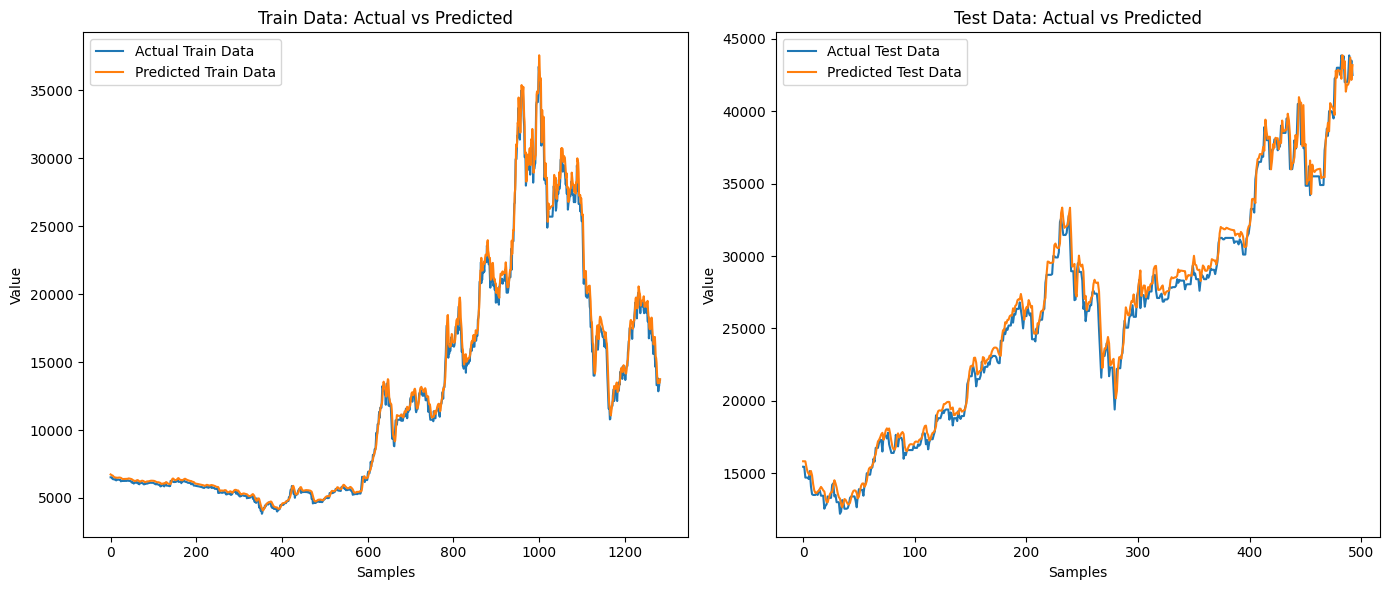

In [14]:
# Vẽ giá trị dự đoán và giá trị thực tế cho tập kiểm tra
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual Train Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual Test Data')
plt.plot(y_pred, label='Predicted Test Data')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))
print('Testing RMSE:', test_rmse)

mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f'Testing MAPE: {mape}')

mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Testing MAE: {mae}')

Testing RMSE: 827.5562436481091
Testing MAPE: 0.025797639905795172
Testing MAE: 632.0691735072263


In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30_days=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30_days.extend(yhat.tolist())
        i=i+1

0 day input [0.27659904 0.27659904 0.27035206 0.2491123  0.23411954 0.24661351
 0.24036652 0.24036652 0.24036652 0.21787737 0.23911713 0.24411471
 0.22162557 0.22037617 0.22037617 0.22037617 0.22037617 0.24161592
 0.24786291 0.2491123  0.24661351 0.24661351 0.24661351 0.24661351
 0.24786291 0.26285567 0.25910748 0.26410507 0.26410507 0.26410507
 0.26660386 0.28659422 0.29034241 0.29034241 0.29034241 0.29034241
 0.29034241 0.29034241 0.29034241 0.29034241 0.29034241 0.27160145
 0.27160145 0.27160145 0.26910266 0.28284603 0.25660869 0.24286532
 0.24161592 0.24161592 0.24161592 0.24411471 0.24161592 0.2491123
 0.2491123  0.24036652 0.24036652 0.24036652 0.21787737 0.22287496
 0.22537376 0.23911713 0.23661833 0.23661833 0.23661833 0.25910748
 0.26160627 0.23911713 0.24161592 0.22912195 0.22912195 0.22912195
 0.20913159 0.21287979 0.23287014 0.23037135 0.21787737 0.21787737
 0.21787737 0.21912677 0.22537376 0.23661833 0.23911713 0.23911713
 0.23911713 0.23911713 0.23162074 0.22037617 0.2416

In [17]:
#14. Dự đoán 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60_days=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.51023631 0.51023631 0.51023631 0.50648812 0.52897727 0.52023149
 0.53772305 0.54397003 0.54397003 0.54397003 0.56146159 0.56271099
 0.60768929 0.62143266 0.62143266 0.62143266 0.62143266 0.62143266
 0.62268206 0.65391699 0.65391699 0.65141819 0.65141819 0.65141819
 0.66016397 0.71263865 0.71888564 0.70389287 0.6901495  0.6901495
 0.6901495  0.69389769 0.71138925 0.72388323 0.68140372 0.62767964
 0.62767964 0.62767964 0.57770376 0.57895316 0.62518085 0.64142301
 0.62643025 0.62643025 0.62643025 0.61143748 0.56271099 0.57395557
 0.54147124 0.5589628  0.5589628  0.5589628  0.56895798 0.56895798
 0.59144713 0.59394592 0.58894833 0.58894833 0.58894833 0.57145677
 0.52522908 0.48399897 0.44401826 0.48150018 0.48150018 0.48150018
 0.49399415 0.50398933 0.48649776 0.44651706 0.46150982 0.46150982
 0.46150982 0.42402791 0.38904479 0.42277851 0.45901103 0.46026042
 0.46026042 0.46026042 0.48150018 0.48649776 0.52647847 0.54272064
 0.530

In [18]:
#14. Dự đoán 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90_days=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.6901495  0.69389769 0.71138925 0.72388323 0.68140372 0.62767964
 0.62767964 0.62767964 0.57770376 0.57895316 0.62518085 0.64142301
 0.62643025 0.62643025 0.62643025 0.61143748 0.56271099 0.57395557
 0.54147124 0.5589628  0.5589628  0.5589628  0.56895798 0.56895798
 0.59144713 0.59394592 0.58894833 0.58894833 0.58894833 0.57145677
 0.52522908 0.48399897 0.44401826 0.48150018 0.48150018 0.48150018
 0.49399415 0.50398933 0.48649776 0.44651706 0.46150982 0.46150982
 0.46150982 0.42402791 0.38904479 0.42277851 0.45901103 0.46026042
 0.46026042 0.46026042 0.48150018 0.48649776 0.52647847 0.54272064
 0.53022667 0.53022667 0.53022667 0.54646883 0.55271581 0.55146642
 0.56895798 0.54896762 0.54896762 0.54896762 0.58520014 0.59269652
 0.61268688 0.56396039 0.58644954 0.58644954 0.58644954 0.56645918
 0.57895316 0.58644954 0.58020255 0.59269652 0.59269652 0.59269652
 0.61893386 0.61893386 0.62143266 0.59394592 0.58145195 0.58145195
 0.58

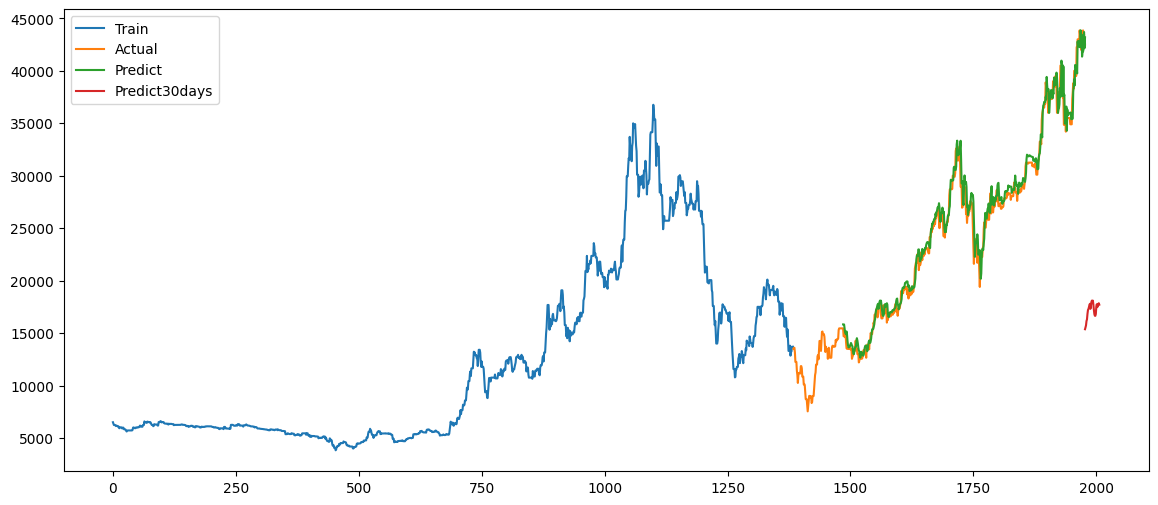

In [19]:
# 14.Vẽ hình 30 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_30_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30_days, scaler.inverse_transform(lst_output_30_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()


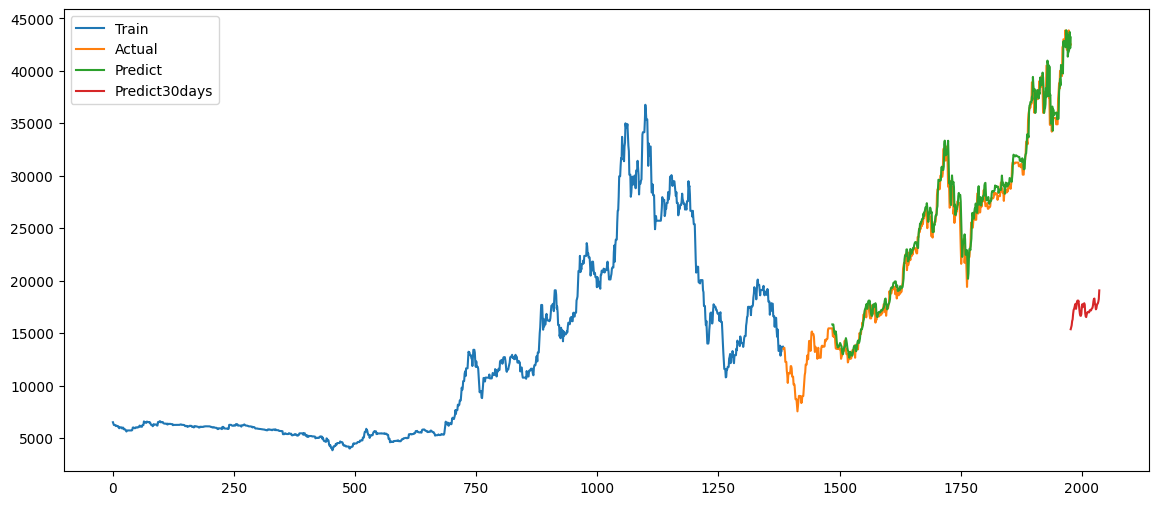

In [20]:
# 14.Vẽ hình 60 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_60_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60_days, scaler.inverse_transform(lst_output_60_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()

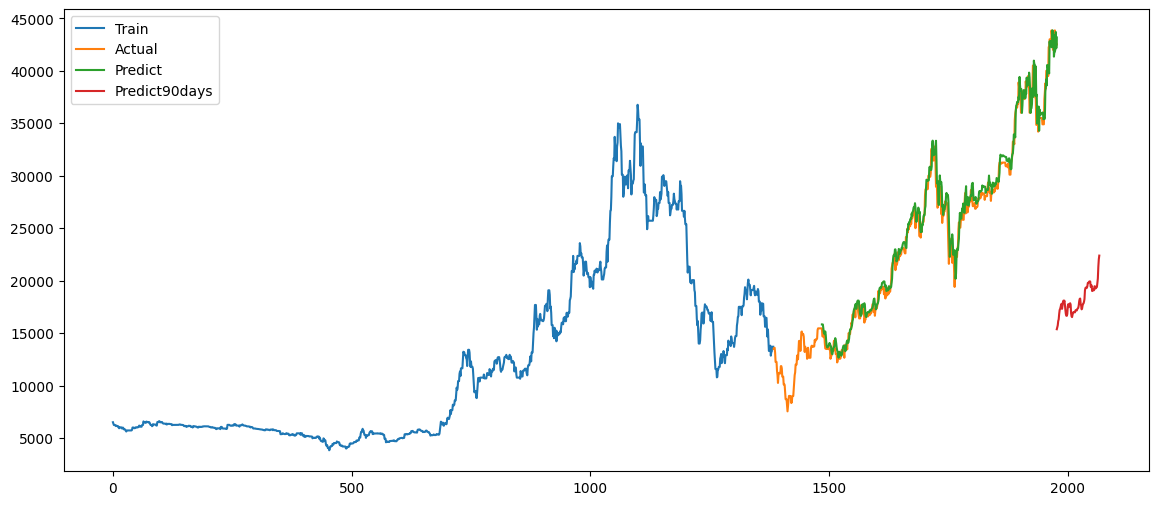

In [21]:
# 14.Vẽ hình 90 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_90_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90_days, scaler.inverse_transform(lst_output_90_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict90days'])
plt.show()

# ACB

In [22]:
# 2. Đọc file csv và gắng index với giá Close
df2= pd.read_csv('DataACB.csv')
df_ACB=df2.reset_index()['Price']

In [23]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_ACB=scaler.fit_transform(np.array(df_ACB).reshape(-1,1))

In [24]:
df_ACB

array([[0.10626062],
       [0.08697082],
       [0.09048058],
       ...,
       [0.77797739],
       [0.7356102 ],
       [0.7356102 ]])

In [25]:
# 4. Chia train test
train_size = int(len(df_ACB) * 0.7)
test_size = len(df_ACB) - train_size
train_data, test_data = df_ACB[0:train_size, :], df_ACB[train_size:len(df_ACB), :1]


In [26]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [27]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [28]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [30]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 10s 226ms/step - loss: 0.0688
Epoch 2/100
21/21 [==============================] - 3s 157ms/step - loss: 0.0044
Epoch 3/100
21/21 [==============================] - 3s 150ms/step - loss: 0.0021
Epoch 4/100
21/21 [==============================] - 3s 151ms/step - loss: 0.0018
Epoch 5/100
21/21 [==============================] - 5s 225ms/step - loss: 0.0018
Epoch 6/100
21/21 [==============================] - 3s 152ms/step - loss: 0.0021
Epoch 7/100
21/21 [==============================] - 3s 151ms/step - loss: 0.0019
Epoch 8/100
21/21 [==============================] - 3s 152ms/step - loss: 0.0019
Epoch 9/100
21/21 [==============================] - 5s 224ms/step - loss: 0.0017
Epoch 10/100
21/21 [==============================] - 3s 150ms/step - loss: 0.0017
Epoch 11/100
21/21 [==============================] - 3s 151ms/step - loss: 0.0017
Epoch 12/100
21/21 [==============================] - 3s 166ms/step - loss: 0.0017
Epoch 13/100

In [31]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

16/16 [==============================] - 1s 35ms/step


In [32]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

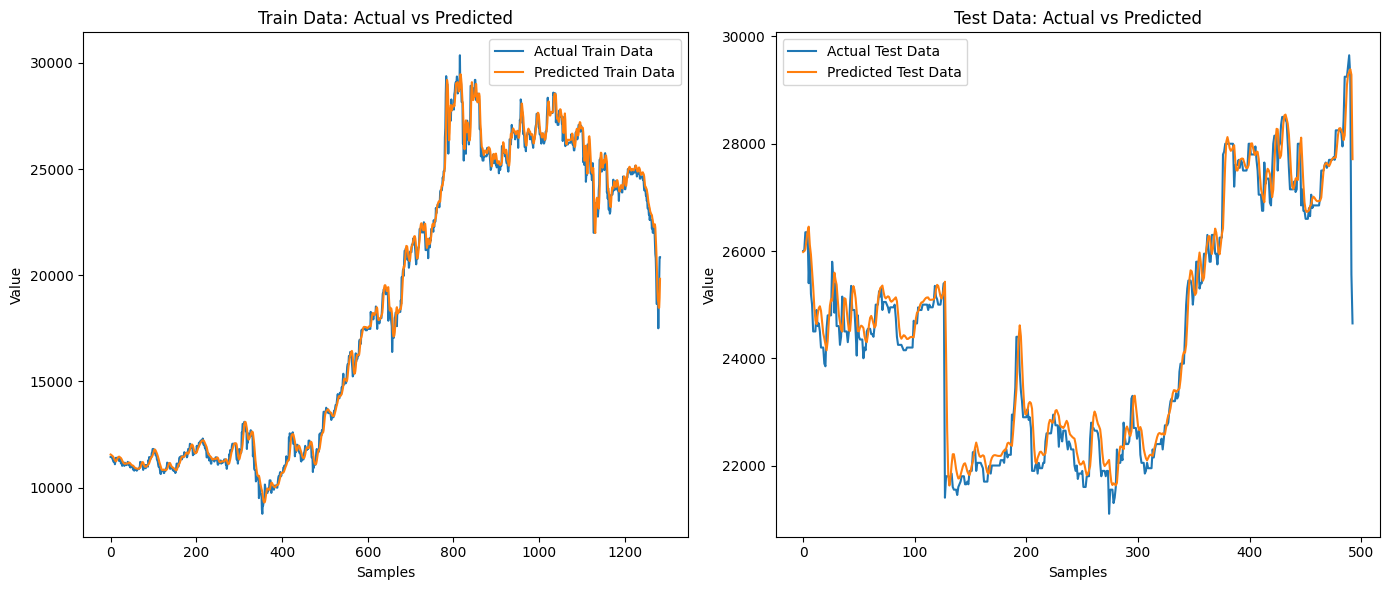

In [33]:
# Vẽ giá trị dự đoán và giá trị thực tế cho tập kiểm tra
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual Train Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual Test Data')
plt.plot(y_pred, label='Predicted Test Data')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))
print('Testing RMSE:', test_rmse)

mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f'Testing MAPE: {mape}')

mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Testing MAE: {mae}')

Testing RMSE: 454.6873763977315
Testing MAPE: 0.011763138416525895
Testing MAE: 284.0318482188134


In [35]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30_days=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30_days.extend(yhat.tolist())
        i=i+1

0 day input [0.65921035 0.65921035 0.64763461 0.63837403 0.64994976 0.65458006
 0.65458006 0.65458006 0.65458006 0.6175377  0.6175377  0.61290741
 0.61290741 0.60827711 0.60827711 0.60827711 0.60827711 0.64531947
 0.64300432 0.65226491 0.66615579 0.66615579 0.66615579 0.66384064
 0.68004667 0.71477388 0.72866476 0.71245873 0.71245873 0.71245873
 0.75181623 0.76570712 0.7749677  0.79811917 0.79811917 0.79811917
 0.79811917 0.79811917 0.79811917 0.79811917 0.79811917 0.8143252
 0.8143252  0.8143252  0.77033741 0.80043432 0.76107682 0.75181623
 0.72866476 0.72866476 0.72866476 0.74718594 0.73329506 0.7356102
 0.72866476 0.71477388 0.71477388 0.71477388 0.700883   0.69856785
 0.73097991 0.74255564 0.74255564 0.74255564 0.74255564 0.78885859
 0.7749677  0.74487079 0.77033741 0.73329506 0.73329506 0.73329506
 0.71708903 0.72403447 0.75876167 0.75413138 0.72866476 0.72866476
 0.72866476 0.71940417 0.72866476 0.75181623 0.76802226 0.74718594
 0.74718594 0.74718594 0.72866476 0.70782844 0.74255

In [36]:
#14. Dự đoán 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60_days=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.60827711 0.60827711 0.60827711 0.61290741 0.61522256 0.60596197
 0.61522256 0.61059226 0.61059226 0.61059226 0.61522256 0.61522256
 0.63374373 0.64068917 0.64068917 0.64068917 0.64068917 0.64068917
 0.64763461 0.6568952  0.65458006 0.64763461 0.64763461 0.64763461
 0.62911344 0.64763461 0.63837403 0.63374373 0.64300432 0.64300432
 0.64300432 0.63374373 0.62679829 0.63374373 0.63142858 0.62679829
 0.62679829 0.62679829 0.61290741 0.60827711 0.61290741 0.60133167
 0.60596197 0.60596197 0.60596197 0.60827711 0.59438623 0.59438623
 0.59438623 0.60364682 0.60364682 0.60364682 0.63605888 0.64994976
 0.64531947 0.64531947 0.64300432 0.64300432 0.64300432 0.64068917
 0.63374373 0.61522256 0.60364682 0.60827711 0.60827711 0.60827711
 0.60364682 0.60827711 0.60827711 0.57123476 0.59207108 0.59207108
 0.59207108 0.58049535 0.58512564 0.59438623 0.62679829 0.61522256
 0.61522256 0.61522256 0.622168   0.6175377  0.64994976 0.63837403
 0.63

In [37]:
#14. Dự đoán 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90_days=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.64300432 0.63374373 0.62679829 0.63374373 0.63142858 0.62679829
 0.62679829 0.62679829 0.61290741 0.60827711 0.61290741 0.60133167
 0.60596197 0.60596197 0.60596197 0.60827711 0.59438623 0.59438623
 0.59438623 0.60364682 0.60364682 0.60364682 0.63605888 0.64994976
 0.64531947 0.64531947 0.64300432 0.64300432 0.64300432 0.64068917
 0.63374373 0.61522256 0.60364682 0.60827711 0.60827711 0.60827711
 0.60364682 0.60827711 0.60827711 0.57123476 0.59207108 0.59207108
 0.59207108 0.58049535 0.58512564 0.59438623 0.62679829 0.61522256
 0.61522256 0.61522256 0.622168   0.6175377  0.64994976 0.63837403
 0.63142858 0.63142858 0.63142858 0.63374373 0.64531947 0.67078609
 0.67310123 0.64531947 0.64531947 0.64531947 0.63605888 0.64068917
 0.64531947 0.622168   0.61522256 0.61522256 0.61522256 0.60596197
 0.60827711 0.61522256 0.61059226 0.61059226 0.61059226 0.61059226
 0.62679829 0.61985285 0.62679829 0.63142858 0.63142858 0.63142858
 0.63

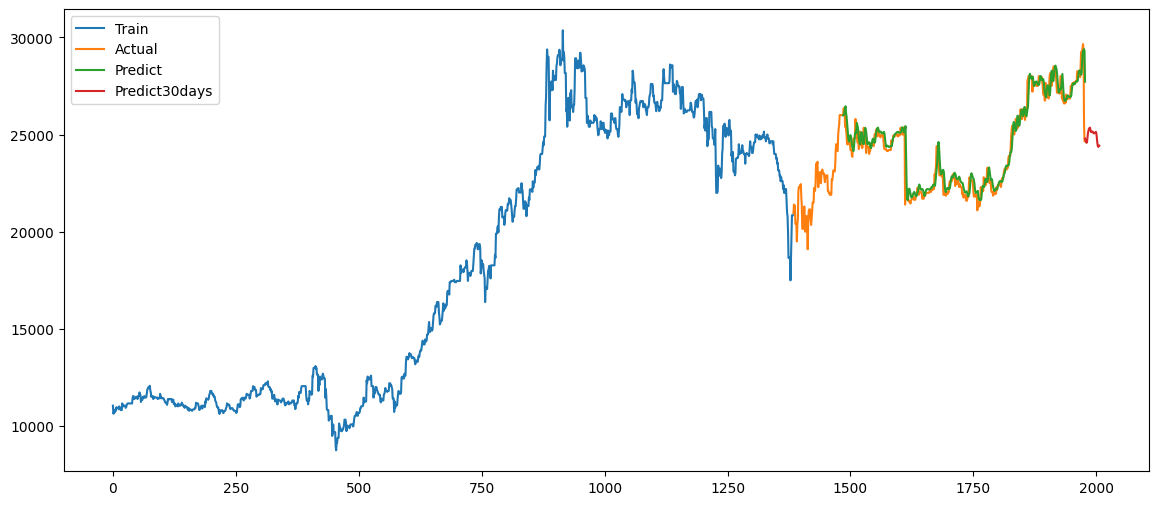

In [38]:
# 14.Vẽ hình 30 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_30_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30_days, scaler.inverse_transform(lst_output_30_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()


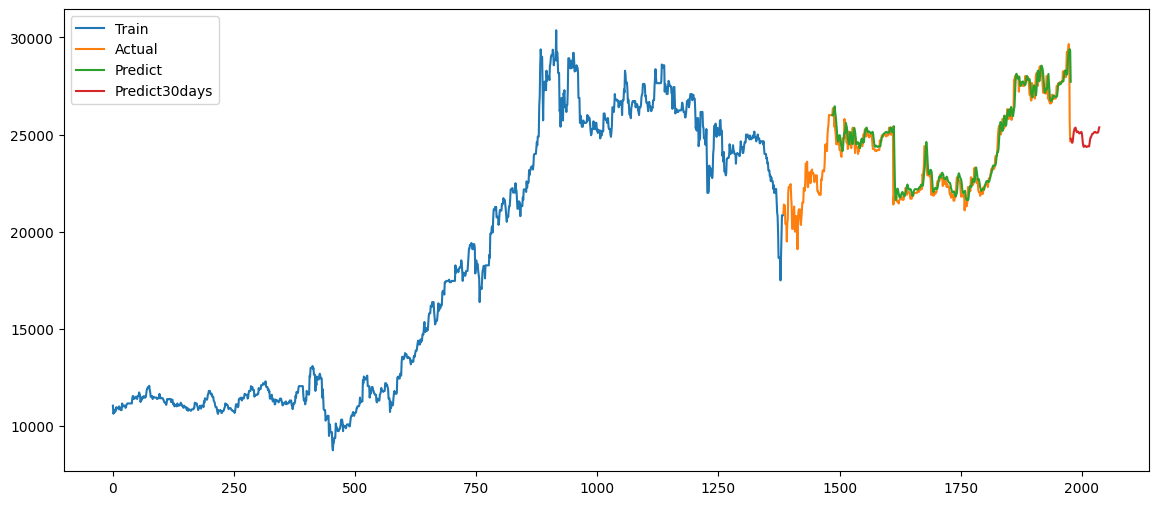

In [39]:
# 14.Vẽ hình 60 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_60_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60_days, scaler.inverse_transform(lst_output_60_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()

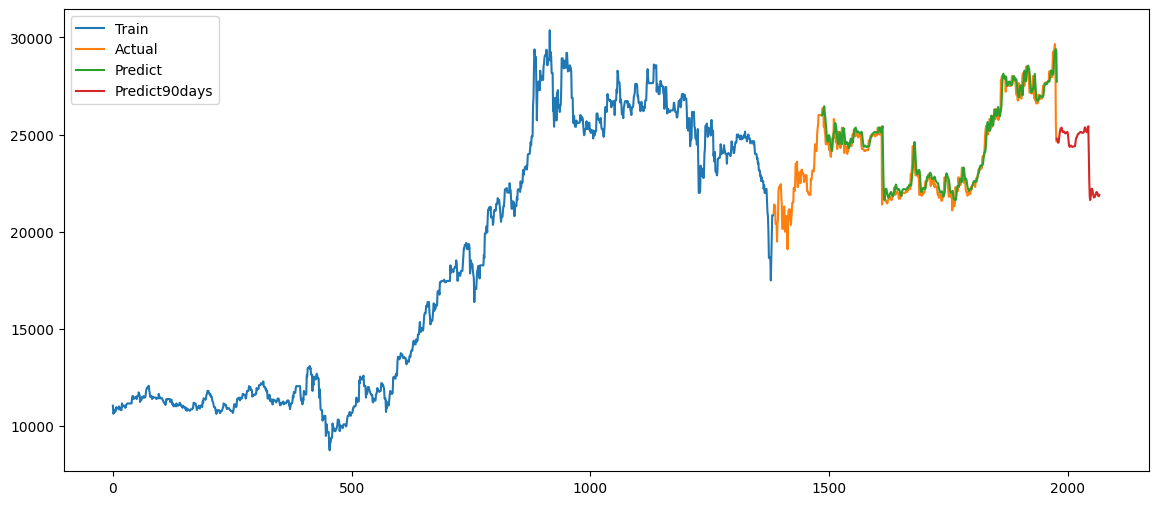

In [40]:
# 14.Vẽ hình 90 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_90_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90_days, scaler.inverse_transform(lst_output_90_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict90days'])
plt.show()

# SBS

In [41]:
# 2. Đọc file csv và gắng index với giá Close
df3= pd.read_csv('DataSBS.csv')
df_SBS=df3.reset_index()['Price']

In [42]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_SBS=scaler.fit_transform(np.array(df_SBS).reshape(-1,1))

In [43]:
df_SBS

array([[0.03960396],
       [0.03465347],
       [0.03465347],
       ...,
       [0.29207921],
       [0.29207921],
       [0.29207921]])

In [44]:
# 4. Chia train test
train_size = int(len(df_SBS) * 0.7)
test_size = len(df_SBS) - train_size
train_data, test_data = df_SBS[0:train_size, :], df_SBS[train_size:len(df_SBS), :1]


In [45]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [46]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [47]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [48]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [49]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 9s 193ms/step - loss: 0.0300
Epoch 2/100
21/21 [==============================] - 4s 185ms/step - loss: 0.0037
Epoch 3/100
21/21 [==============================] - 3s 151ms/step - loss: 0.0024
Epoch 4/100
21/21 [==============================] - 3s 152ms/step - loss: 0.0023
Epoch 5/100
21/21 [==============================] - 4s 207ms/step - loss: 0.0023
Epoch 6/100
21/21 [==============================] - 4s 167ms/step - loss: 0.0021
Epoch 7/100
21/21 [==============================] - 3s 153ms/step - loss: 0.0020
Epoch 8/100
21/21 [==============================] - 3s 148ms/step - loss: 0.0019
Epoch 9/100
21/21 [==============================] - 5s 220ms/step - loss: 0.0020
Epoch 10/100
21/21 [==============================] - 3s 151ms/step - loss: 0.0042
Epoch 11/100
21/21 [==============================] - 3s 151ms/step - loss: 0.0017
Epoch 12/100
21/21 [==============================] - 3s 154ms/step - loss: 0.0016
Epoch 13/100


In [50]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

16/16 [==============================] - 1s 42ms/step


In [51]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

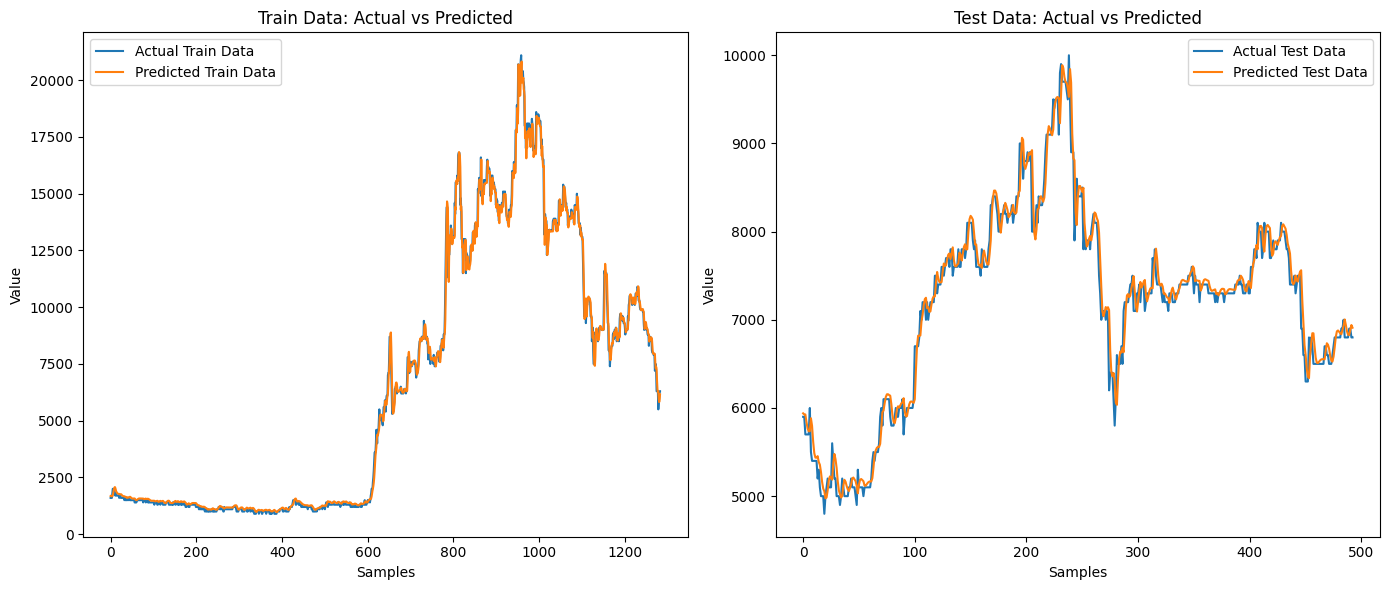

In [52]:
# Vẽ giá trị dự đoán và giá trị thực tế cho tập kiểm tra
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual Train Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual Test Data')
plt.plot(y_pred, label='Predicted Test Data')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))
print('Testing RMSE:', test_rmse)

mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f'Testing MAPE: {mape}')

mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Testing MAE: {mae}')

Testing RMSE: 182.10981169859485
Testing MAPE: 0.017522770152209925
Testing MAE: 122.83818082055019


In [54]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30_days=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30_days.extend(yhat.tolist())
        i=i+1

0 day input [0.23267327 0.23267327 0.23267327 0.21782178 0.21782178 0.21287129
 0.20792079 0.20792079 0.20792079 0.18811881 0.21287129 0.21287129
 0.2029703  0.2029703  0.2029703  0.2029703  0.2029703  0.22772277
 0.21782178 0.21782178 0.20792079 0.20792079 0.20792079 0.21287129
 0.21287129 0.21287129 0.21782178 0.21287129 0.21287129 0.21287129
 0.21782178 0.22772277 0.22772277 0.24752475 0.24752475 0.24752475
 0.24752475 0.24752475 0.24752475 0.24752475 0.24752475 0.23762376
 0.23762376 0.23762376 0.23762376 0.25247525 0.22772277 0.22277228
 0.22277228 0.22277228 0.22277228 0.22277228 0.21287129 0.21782178
 0.20792079 0.2029703  0.2029703  0.2029703  0.19306931 0.2029703
 0.20792079 0.21287129 0.20792079 0.20792079 0.20792079 0.23267327
 0.22277228 0.21287129 0.21287129 0.2029703  0.2029703  0.2029703
 0.1980198  0.2029703  0.21287129 0.20792079 0.2029703  0.2029703
 0.2029703  0.2029703  0.20792079 0.20792079 0.21287129 0.20792079
 0.20792079 0.20792079 0.2029703  0.1980198  0.217821

In [55]:
#14. Dự đoán 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60_days=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.35148515 0.35148515 0.35148515 0.35643564 0.36633663 0.35643564
 0.37128713 0.36633663 0.36633663 0.36633663 0.37128713 0.38118812
 0.3960396  0.40594059 0.40594059 0.40594059 0.40594059 0.40594059
 0.41089109 0.42574257 0.42079208 0.42574257 0.42574257 0.42574257
 0.40594059 0.44059406 0.44554455 0.43564356 0.43564356 0.43564356
 0.43564356 0.43069307 0.42574257 0.45049505 0.42574257 0.3960396
 0.3960396  0.3960396  0.34653465 0.36138614 0.38118812 0.37128713
 0.37128713 0.37128713 0.37128713 0.37623762 0.34158416 0.35148515
 0.34158416 0.34653465 0.34653465 0.34653465 0.34158416 0.35148515
 0.35643564 0.36138614 0.35643564 0.35643564 0.35643564 0.34653465
 0.32673267 0.31683168 0.3019802  0.30693069 0.30693069 0.30693069
 0.3019802  0.30693069 0.3019802  0.26237624 0.27227723 0.27227723
 0.27227723 0.25742574 0.24257426 0.25742574 0.28217822 0.27722772
 0.27722772 0.27722772 0.28712871 0.27722772 0.30693069 0.31188119
 0.311

In [56]:
#14. Dự đoán 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90_days=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.43564356 0.43069307 0.42574257 0.45049505 0.42574257 0.3960396
 0.3960396  0.3960396  0.34653465 0.36138614 0.38118812 0.37128713
 0.37128713 0.37128713 0.37128713 0.37623762 0.34158416 0.35148515
 0.34158416 0.34653465 0.34653465 0.34653465 0.34158416 0.35148515
 0.35643564 0.36138614 0.35643564 0.35643564 0.35643564 0.34653465
 0.32673267 0.31683168 0.3019802  0.30693069 0.30693069 0.30693069
 0.3019802  0.30693069 0.3019802  0.26237624 0.27227723 0.27227723
 0.27227723 0.25742574 0.24257426 0.25742574 0.28217822 0.27722772
 0.27722772 0.27722772 0.28712871 0.27722772 0.30693069 0.31188119
 0.31188119 0.31188119 0.31188119 0.31683168 0.32178218 0.32178218
 0.32673267 0.30693069 0.30693069 0.30693069 0.31683168 0.31683168
 0.32178218 0.31188119 0.32178218 0.32178218 0.32178218 0.30693069
 0.31188119 0.31683168 0.31683168 0.31683168 0.31683168 0.31683168
 0.33663366 0.33168317 0.34158416 0.32673267 0.32178218 0.32178218
 0.321

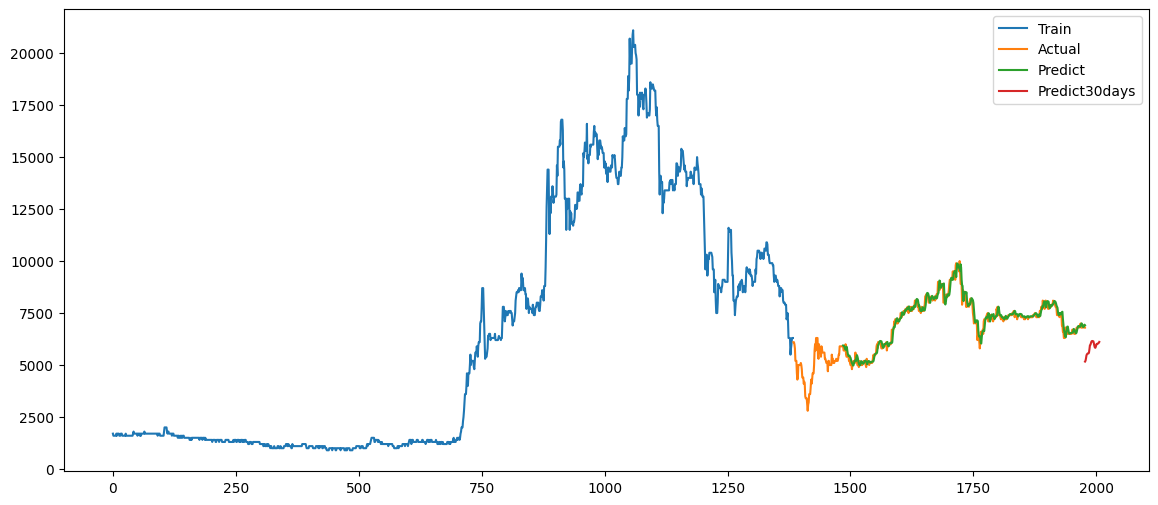

In [57]:
# 14.Vẽ hình 30 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_30_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30_days, scaler.inverse_transform(lst_output_30_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()


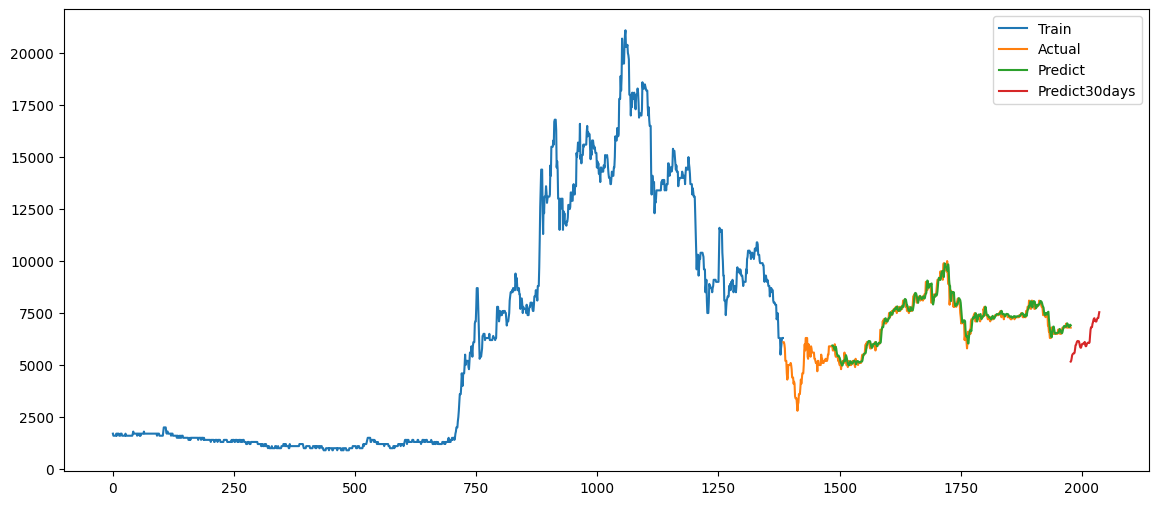

In [58]:
# 14.Vẽ hình 60 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_60_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60_days, scaler.inverse_transform(lst_output_60_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()

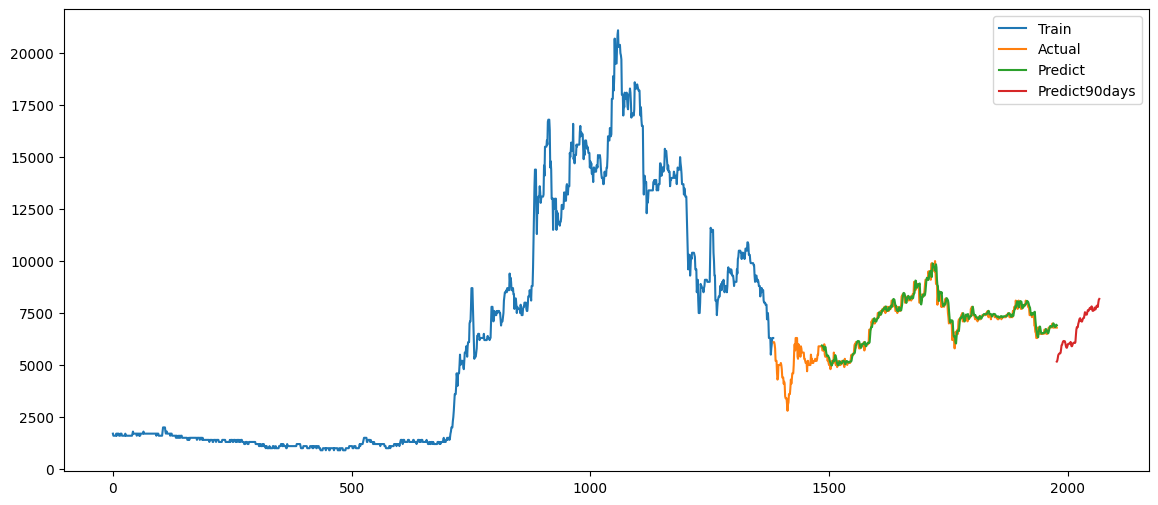

In [59]:
# 14.Vẽ hình 90 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_90_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90_days, scaler.inverse_transform(lst_output_90_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict90days'])
plt.show()